#### 经过处理,已经将大部分异常值从数据集中筛选出来了,接下来就是训练自己的模型了

In [1]:
from sklearn.datasets import load_files
from keras.utils import np_utils
import numpy as np

def load_dataset(path):
    '''加载数据的方法'''
    data = load_files(path)
    print(type(data))
    data_files = np.array(data['filenames'])
    #target直接是0,1
    data_targets = np.array(data['target'])
    return data_files,data_targets

Using TensorFlow backend.


In [2]:
#创建直接加载数据集并直接分割的方法

def load_all_data(data_dir='train_set',test_size=0.2,random_state=8888):
    #加载所有的处理过的猫狗数据
    train_files,train_targets=load_dataset(data_dir)
    #打印下看看有没有问题
    print(train_files[0],train_targets[0])
    from sklearn.model_selection import train_test_split
    import numpy as np
    X=train_files
    Y=train_targets
    x_train,x_valid,y_train,y_valid=train_test_split(X,Y,test_size=test_size,random_state=np.random.randint())
    return x_train,x_valid,y_train,y_valid
    

In [3]:
#加载所有的处理过的猫狗数据
train_files,train_targets=load_dataset('train_set')
#打印下看看有没有问题
print(train_files[0],train_targets[0])

<class 'sklearn.utils.Bunch'>
train_set/cat/cat.3557.jpg 0


In [4]:
#展示Accuracy数据
import matplotlib.pyplot as plt

def show_acc(history):
    print(history.history.keys())
    figure=plt.figure()
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Model accucary')
    plt.xlabel('accuracy')
    plt.ylabel('epoch')
    #注意!
    plt.legend(['train','valid'],loc='upper left')
    figure.savefig('performance_acc.png')
    

#展示Loss数据  
def show_loss(history):
    print(history.history.keys())
    figure=plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Loss')
    plt.ylabel('epoch')
    #注意!
    plt.legend(['train','valid'],loc='upper left')
    figure.savefig('performance_loss.png')

In [4]:
#注意,不能直接加载数据集然后再分割,因为这样很占用内存
from sklearn.model_selection import train_test_split

X=train_files
Y=train_targets
x_train,x_valid,y_train,y_valid=train_test_split(X,Y,test_size=0.2,random_state=1234)

In [ ]:
#展示模型,因为要安装额外软件,所以linux就注释掉了
#from keras.utils import plot_model
#pip install pydot
#pip install pydot-ng
#pip install graphviz 
#参考https://blog.csdn.net/u011311291/article/details/80298563
#https://packages.ubuntu.com/search?keywords=graphviz&searchon=names
#plot_model(model, to_file='model.png',show_shapes=True)

In [5]:
#另一种可视化模型的方法
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [11]:
#接下来的处理方式是将所有的图片都处理成向量
from keras.preprocessing import image
from keras.applications.inception_resnet_v2 import preprocess_input as ir_preprocess_input
from tqdm import tqdm

##pip install  tqdm
#注意要安装tqdm
def path_to_tensor(image_path,target_size=(299,299)):
    '''将图片转换为tensor向量'''
    img=image.load_img(image_path,target_size=target_size)
    x=image.img_to_array(img)
    x=ir_preprocess_input(x)
    return np.expand_dims(x,axis=0)

def paths_to_tensor(image_paths):
    '''批量将图片转换为tensor'''
    list_of_tensor=[path_to_tensor(image_path) for image_path in tqdm(image_paths)]
    return np.vstack(list_of_tensor)
    

In [6]:
from pandas import DataFrame

#预测并输出结果到csv文件
def predict_and_to_csv(test_dir,result_file):
    image_paths=load_image_paths(test_dir)
    result=predict_images(model,image_paths)
    dataframe=DataFrame(result)
    dataframe.index = np.arange(1, len(dataframe)+1)
    dataframe.to_csv(result_file,index_label ='id',header=['label'])
    return image_paths,result

In [7]:
#写个方法加载验证集数据
import glob
import numpy as np
import os

def load_image_paths(path):
    '''输入相对路径,得到所有图片文件名'''
    paths=[]
    for i in range(1,12501):
        paths.append(path+str(i)+'.jpg')
    if len(paths)>0:
        return  np.array(paths)
    else:
        return None
    
def predict_images(model,file_names):
    '''根据名字输出是狗的概率'''
    x=paths_to_tensor(file_names)
    return model.predict(x)
    

In [8]:
from pandas import DataFrame

def array_to_csv(array):
    dataframe=DataFrame(array)
    dataframe.index = np.arange(1, len(dataframe)+1)
    dataframe.to_csv('result.csv',index_label ='id',header=['label'])

####  接下来,进行首次加载基准模型的尝试,并锁住基准模型中所有的层,添加新的层进行训练.
所做的操作有:
* 使用的整体数据的一小部分
* 加载好预训练好的InceptionResNetV2以及权重
* 在base_model的基础上增加Dense层和Dropout层
* 训练,将具有最佳val_acc时的模型权重保存起来

In [5]:
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras import Model


base_model=InceptionResNetV2(weights='imagenet',include_top=False)
#将基准模型中的层全部锁住
for layer in base_model.layers:
    layer.trainable=False

x=GlobalAveragePooling2D()(base_model.output)
x=Dense(512)(x)
x=Dropout(0.2)(x)
# 添加一个分类器，我们有2个类
predictions=Dense(1,activation='sigmoid')(x)

# 构建我们需要训练的完整模型
model = Model(inputs=base_model.input, outputs=predictions)

model.compile(loss='binary_crossentropy',optimizer='Adam',metrics=['accuracy'])
for i, layer in enumerate(model.layers):
    print(i, layer.name)
    
#输出模型的样式
model.summary()

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed_5b
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 conv2d_13
51 conv2d_15
52 conv2d_18
53 batch_normalization_13
54 batch_normalization_15
55 batch_normalization

block17_5_conv (Conv2D)         (None, None, None, 1 418880      block17_5_mixed[0][0]            
__________________________________________________________________________________________________
block17_5 (Lambda)              (None, None, None, 1 0           block17_4_ac[0][0]               
                                                                 block17_5_conv[0][0]             
__________________________________________________________________________________________________
block17_5_ac (Activation)       (None, None, None, 1 0           block17_5[0][0]                  
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, None, None, 1 139264      block17_5_ac[0][0]               
__________________________________________________________________________________________________
batch_normalization_98 (BatchNo (None, None, None, 1 384         conv2d_98[0][0]                  
__________

In [9]:
from keras.callbacks import ModelCheckpoint
import os
#开始训练模型
###设置训练模型的epochs的数量
epochs = 15
batch_size=50
check_point_filepath='./saved_models/weights.best-{epoch:02d}-{val_acc:.2f}.hdf5'
saved_model_path='./saved_models'

#文件夹不存在,就创建文件夹
if not os.path.exists(saved_model_path):
    os.mkdir()
    
####设置检查点
checkpointer = ModelCheckpoint(filepath=check_point_filepath, monitor='val_acc',verbose=1, save_best_only=True)

#设置回调
call_back=[checkpointer]

#加载数据
x_train_data=paths_to_tensor(x_train)
x_valid_data=paths_to_tensor(x_valid)

100%|██████████| 4967/4967 [00:27<00:00, 183.64it/s]


In [17]:
#开始训练
epochs=15
history= model.fit(x_train_data,y_train,validation_data=(x_valid_data,y_valid),epochs=epochs,batch_size=50,callbacks=call_back)

Train on 19868 samples, validate on 4967 samples
Epoch 1/15
19868/19868 [==============================] - 165s 8ms/step - loss: 0.0349 - acc: 0.9883 - val_loss: 0.1207 - val_acc: 0.9644

Epoch 00001: val_acc did not improve from 0.98752
Epoch 2/15
19868/19868 [==============================] - 164s 8ms/step - loss: 0.0391 - acc: 0.9863 - val_loss: 0.0978 - val_acc: 0.9748

Epoch 00002: val_acc did not improve from 0.98752
Epoch 3/15
19868/19868 [==============================] - 164s 8ms/step - loss: 0.0357 - acc: 0.9868 - val_loss: 0.0585 - val_acc: 0.9841

Epoch 00003: val_acc did not improve from 0.98752
Epoch 4/15
19868/19868 [==============================] - 164s 8ms/step - loss: 0.0348 - acc: 0.9882 - val_loss: 0.0420 - val_acc: 0.9881

Epoch 00004: val_acc improved from 0.98752 to 0.98812, saving model to ./saved_models/weights.best-04-0.99.hdf5
Epoch 5/15
19868/19868 [==============================] - 164s 8ms/step - loss: 0.0345 - acc: 0.9878 - val_loss: 0.0423 - val_acc: 0.

#### 在训练时遭遇了一个严重问题,在使用数据集5000,epoch=10,batch_size=50的时候,验证集的val_loss:保持在8.2847 ,val_acc:固定在0.4860,令人费解.
#### 我做了如下尝试:
* 1.停止训练,检查load_files,得到的数据,图片和target是一一对应的
* 2.减少了训练集大小和epoch和batch_size来加快训练速度
* 3.修改了model compile时使用的损失函数,从accuracy 改成binary_accuracy

#### 经过查找原因,发现是数据集太小,模型无法收敛了导致的
#### 解决方案:
* 使用云服务器,有aws和gcp等几个可以选择,我使用gcp继续进行模型的训练 

#### 在经过训练后,我又发现了上次类似的问题,验证集数据准确率只有0.51左右.最先考虑的情况是epoch太少,所以选择10-->30,发现作用不大
#### 问题原因:
* 数据集未经过预处理,且预处理的方法是InceptionResNet50独有的,这点需要注意


#### 经过训练.发现上面两图中的Loss在epoch=5的时候就到达了最大.Accurcy差不多是最高的,所以判断epoch<10内模型就应该收敛了,于是重新训练 并且将输入尺寸从224 * 224  改成模型默认的299 * 299

#### 在训练时,使用不同的batch_size,曲线有的变化很大,batch_size为40的时候,曲线比较平缓,在bacth_size分别为35,50,30的时候,学习曲线都上下震荡,所有就把40默认成训练时的batch_size

#### 在锁层并得到比较好的val_acc时,保存了权重,并加载这部分权重.然后尝试开放部分层来检测结果
所做过的尝试有:
* 只训练617-776层,在此之上的层锁住,得到的最终分数为0.22848
* 617以后的层都不锁, 训练.最终分数为0.16487``

#### 上面的方案尝试过后,决定修改策略.就是base_model直接锁层,只训练一次权重.
然后做过的尝试有:
* 只训练base_model的617-776层,最终分数是0.10634
*  260以后的层不锁,训练.最终分数是0.12924
* 全部不锁层,最终分数是:0.09176

####  开放更多层还是出现验证集Loss很低,但是测试集损失0.1左右,认为还是过拟合.
#### 猜测此模型可能容易发生过拟合.将采取下一个方案:
* 使用数据增强的方式

In [15]:
####接下来,开启使用数据增强的方式来进行微调

In [9]:
#18:27 继续训练,开放更多层
# 加载权重,进行fine-tune
from keras.callbacks import  EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.layers import Dropout
from keras import Model


base_model=InceptionResNetV2(weights='imagenet',include_top=False)
for layer in base_model.layers:
    layer.trainable=False
    
x=GlobalAveragePooling2D()(base_model.output)
x=Dense(512)(x)
x=Dropout(0.2)(x)
# 添加一个分类器，我们有2个类
predictions=Dense(1,activation='sigmoid')(x)

# 构建我们需要训练的完整模型
model = Model(inputs=base_model.input, outputs=predictions)
#先加载权重
# model.load_weights('./saved_models/weights.best-01-0.99477.hdf5')

# #z再锁层
# for layer in model.layers:
#     layer.trainable=False

# #后面的都不锁了,直接训练
# for layer in model.layers[260:]:
#     layer.trainable=True
    
# 记得先编译    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

#增加回调
early_stoping= EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
check_point_filepath='./saved_models/weights.best.062012119.valid-{epoch:02d}-{val_acc:.5f}.hdf5'

####设置检查点
checkpointer = ModelCheckpoint(filepath=check_point_filepath, monitor='val_loss',verbose=1, save_best_only=True)
call_backs=[early_stoping,checkpointer]

#也要更新下样本啊
x_train,x_valid,y_train,y_valid=load_all_data(test_size=0.3,random_state=8888)

# del x_train_data
# del x_valid_data

#加载数据
x_train_data=paths_to_tensor(x_train)
x_valid_data=paths_to_tensor(x_valid)

#使用更小的batch_size进行测试 
history= model.fit(x_train_data,y_train,validation_data=(x_valid_data,y_valid),epochs=50,batch_size=40,callbacks=call_backs)

100%|██████████| 4967/4967 [00:26<00:00, 185.18it/s]


Train on 19868 samples, validate on 4967 samples
Epoch 1/50
19868/19868 [==============================] - 189s 10ms/step - loss: 0.1034 - acc: 0.9687 - val_loss: 0.0418 - val_acc: 0.9909

Epoch 00001: val_loss improved from inf to 0.04182, saving model to ./saved_models/weights.best.06201825.valid-01-0.99094.hdf5
Epoch 2/50
19868/19868 [==============================] - 178s 9ms/step - loss: 0.0577 - acc: 0.9801 - val_loss: 0.0704 - val_acc: 0.9813

Epoch 00002: val_loss did not improve from 0.04182
Epoch 3/50
19868/19868 [==============================] - 177s 9ms/step - loss: 0.0463 - acc: 0.9841 - val_loss: 0.0450 - val_acc: 0.9907

Epoch 00003: val_loss did not improve from 0.04182
Epoch 4/50
19868/19868 [==============================] - 177s 9ms/step - loss: 0.0446 - acc: 0.9843 - val_loss: 0.0640 - val_acc: 0.9849

Epoch 00004: val_loss did not improve from 0.04182
Epoch 5/50
19868/19868 [==============================] - 178s 9ms/step - loss: 0.0499 - acc: 0.9826 - val_loss: 0

dict_keys(['acc', 'loss', 'val_loss', 'val_acc'])
dict_keys(['acc', 'loss', 'val_loss', 'val_acc'])


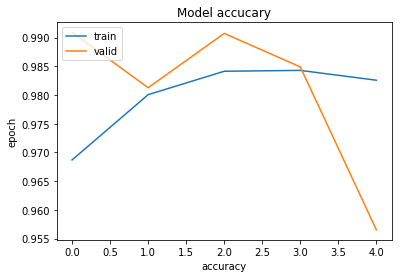

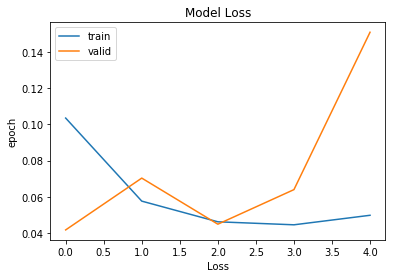

In [10]:
show_acc(history)
show_loss(history)

In [15]:
#加载权重]
model.load_weights('./saved_models/weights.best.06201825.valid-01-0.99094.hdf5')
paths,array=predict_and_to_csv('./test/','result06201827.csv')

100%|██████████| 12500/12500 [01:10<00:00, 177.71it/s]


In [30]:
#在此之前还要做一个重要的工作,就是提取bottleneck_feature,这样就不用再训练模型的时候加载很久了
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import preprocess_input

from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Lambda,Input,GlobalAveragePooling2D
import numpy as np
import h5py
import os
import shutil

def rm_rf_and_mkdir(dirname):
    '''删除该目录下所有文件,如果不存在该文件夹,则新建'''
    if os.path.exists(dirname):
        shutil.rmtree(dirname)
    os.mkdir(dirname)


def save_bottlebeck_feature(target_size=(299,299)):
    '''提取瓶颈特征'''
    image_width=target_size[0]
    imgae_height=target_size[1]
    input_tensor=Input((image_width,imgae_height,3))
    x=input_tensor
    x=Lambda(preprocess_input)(x)
    
    base_model=InceptionResNetV2(weights='imagenet',include_top=False,input_tensor=x)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output)) 

    generator=ImageDataGenerator()
    
    train_generator=generator.flow_from_directory('train_set',target_size,shuffle=False,batch_size=50)
    test_generator=generator.flow_from_directory('test_set',target_size,shuffle=False,class_mode=None,batch_size=50)
    print(len(train_generator.classes))
    train=model.predict_generator(train_generator,use_multiprocessing=True,verbose=1)
    test=model.predict_generator(test_generator,use_multiprocessing=True,verbose=1)

    with h5py.File('inception_resnetv2.h5') as h:
        h.create_dataset("train",data=train)
        h.create_dataset("test",data=test)
        #train_targets
        h.create_dataset("label",data=train_generator.classes)

    



#删除test_set文件夹,并为原目录创建软连接
rm_rf_and_mkdir('test_set')
os.symlink('../test/', 'test_set/test')
    
save_bottlebeck_feature(target_size=(299,299))

Found 24835 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
24835
250/250 [==============================] - 122s 489ms/step


In [31]:
from keras.models import *
from keras.layers import * 
from keras.callbacks import EarlyStopping, ModelCheckpoint
import h5py
import numpy as np
from keras.optimizers import SGD
from sklearn.utils import shuffle

X_train=[]
X_test=[]
file_name='inception_resnetv2.h5'
with h5py.File(file_name,'r') as h:
    X_train=np.array(h['train'])
    X_test=np.array(h['test'])
    y_train=np.array(h['label'])
    
print(len(X_train))
print(len(X_test))
print(len(y_train))

X_train,y_train=shuffle(X_train,y_train)

np.random.seed(8282)

input_tensor=Input(X_train.shape[1:])
x=Dropout(0.2)(input_tensor)
x=Dense(1,activation='sigmoid')(x)
model=Model(input_tensor,x)

model.summary()
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

#增加回调
early_stoping= EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')
check_point_filepath='./saved_models/weights.best.06211223.valid-{epoch:02d}-{val_acc:.5f}.hdf5'

####设置检查点
checkpointer = ModelCheckpoint(filepath=check_point_filepath, monitor='val_loss',verbose=1, save_best_only=True)
call_backs=[early_stoping,checkpointer]

24835
12500
24835
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 1536)              0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 1537      
Total params: 1,537
Trainable params: 1,537
Non-trainable params: 0
_________________________________________________________________


In [32]:
history=model.fit(X_train, y_train, batch_size=40, epochs=10, validation_split=0.2,callbacks=call_backs)

Train on 19868 samples, validate on 4967 samples
Epoch 1/10
19868/19868 [==============================] - 58s 3ms/step - loss: 0.0518 - acc: 0.9901 - val_loss: 0.0210 - val_acc: 0.9954

Epoch 00001: val_loss improved from inf to 0.02097, saving model to ./saved_models/weights.best.06211223.valid-01-0.99537.hdf5
Epoch 2/10
19868/19868 [==============================] - 7s 362us/step - loss: 0.0168 - acc: 0.9961 - val_loss: 0.0174 - val_acc: 0.9960

Epoch 00002: val_loss improved from 0.02097 to 0.01740, saving model to ./saved_models/weights.best.06211223.valid-02-0.99597.hdf5
Epoch 3/10
19868/19868 [==============================] - 7s 358us/step - loss: 0.0136 - acc: 0.9967 - val_loss: 0.0169 - val_acc: 0.9964

Epoch 00003: val_loss improved from 0.01740 to 0.01693, saving model to ./saved_models/weights.best.06211223.valid-03-0.99638.hdf5
Epoch 4/10
19868/19868 [==============================] - 7s 360us/step - loss: 0.0126 - acc: 0.9963 - val_loss: 0.0151 - val_acc: 0.9964

Epoch 0

In [ ]:
# 我的策略
1.先提取特征
2.使用数据增强
3.锁住一部分层
4.开始训练

In [33]:
y_pred = model.predict(X_test, verbose=1)

12500/12500 [==============================] - 28s 2ms/step


In [34]:
import pandas as pd
from keras.preprocessing.image import *

df =pd.read_csv('sampleSubmission.csv')
gen=ImageDataGenerator()
test_generator=gen.flow_from_directory('test_set',shuffle=False,class_mode=None,batch_size=50)

for i,name in enumerate(test_generator.filenames):
    #去掉 / .之外的字符,剩下的就是图片名称了
    index=int(name[name.rfind('/')+1:name.rfind('.')])
    df.set_value(index-1,'label',y_pred[i])
    
df.to_csv('201806212213predict.csv',index=None)

Found 12500 images belonging to 1 classes.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
